In [1]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import ast

In [2]:
phenotype_ukb=pd.read_excel(r"R:\Medicine\Hematology-Oncology\Godley_Lab\UK_Biobank\Phenotype_Data\Pheno_UKB_Cleaned_020525.xlsx")
phenotype_ukb

,eid,Sex,Age_at_recruitment,ICD10,N_Cancer,Cancer_Date,Collapsed_p40006,Age_at_Cancer,Histology,Behavior,ICD9,Recordformat,RecordOrigin
0,1000019,Male,63.0,"['E039', 'E119', 'E780', 'I10', 'I209', 'I251'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000141,Female,58.0,"['I10', 'J459', 'N811', 'Z880', 'Z910']",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000186,Male,43.0,['K409'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1000248,Female,41.0,"['C504', 'N888', 'N950', 'O360', 'O701', 'O862...",1.0,['2019-08-05'],['C504'],[52.3],[8500.0],[3.0],NaN,[73.0],['E/W']
4,1000255,Male,49.0,"['K449', 'N359', 'N40', 'Z115', 'Z888']",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
502405,6023959,Male,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
502406,6023988,Male,69.0,"['A099', 'A419', 'B956', 'C679', 'C798', 'E86'...",2.0,"['1993-06-30', '1993-06-30']",NaN,"[54.8, 54.8]",[8130.0],[3.0],"[1889.0, 1889.0]","[13.0, 23.0]","['NCIN', 'E/W']"
502407,6024030,Male,65.0,"['D176', 'E119', 'E559', 'E780', 'F171', 'F329...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
502408,6024068,Female,58.0,"['B029', 'G439', 'K219', 'K30', 'M819', 'M858'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#Obtain Cancer Risk participant ids
pid_cancer_risk_all=pd.read_csv("Cancer_risk_pids.csv")
print("Total Participants with P/LP variants in Cancer risk",len(pid_cancer_risk_all['Participant ID'].unique()))
pid_cancer_risk_all_unique=pid_cancer_risk_all['Participant ID'].unique()

#For CHEK2 cohort
pid_cancer_risk = pid_cancer_risk_all[pid_cancer_risk_all['Gene'] != 'CHEK2']

pid_cancer_unique_withoutchek2=pid_cancer_risk['Participant ID'].unique()
print("Without CHEK2",len(pid_cancer_unique_withoutchek2))
print(pid_cancer_risk_all['Gene'].value_counts())
pid_cancer_risk['Gene'].value_counts()
#Removed all the other participants with P/LP variants in Cancer risk genes from UKB
phenotype_ukb=phenotype_ukb[~phenotype_ukb['eid'].isin(pid_cancer_unique_withoutchek2)]
phenotype_ukb


# Ensure columns contain actual lists, not strings
phenotype_ukb["Behavior"] = phenotype_ukb["Behavior"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
phenotype_ukb["Age_at_Cancer"] = phenotype_ukb["Age_at_Cancer"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
phenotype_ukb["Collapsed_p40006"] = phenotype_ukb["Collapsed_p40006"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Define malignant cancer histology codes
malignant_codes = {2.0, 3, 0, 6.0, 9.0}

# Function to extract first cancer code, first malignant behavior, and age at first cancer
def get_first_cancer_info(cancer_codes, hist_codes, ages):
    first_cancer = cancer_codes[0] if isinstance(cancer_codes, list) and cancer_codes else None
    
    if isinstance(hist_codes, list) and isinstance(ages, list):
        for hist_code, age in zip(hist_codes, ages):
            if hist_code in malignant_codes:
                return pd.Series([first_cancer, age, hist_code])
    
    return pd.Series([first_cancer, None, None])  # If no malignant cancer is found

# Apply function to extract the required information
phenotype_ukb[["First_Cancer_Code", "Age_at_First_Cancer", "First_Behavior"]] = phenotype_ukb.apply(
    lambda row: get_first_cancer_info(row["Collapsed_p40006"], row["Behavior"], row["Age_at_Cancer"]), axis=1
)

Total Participants with P/LP variants in Cancer risk 18228
Without CHEK2 14466
Gene
CHEK2     3867
BRCA2     1504
ATM       1485
FANCA     1264
BLM       1080
MPL       1034
FANCD2    1001
FANCC      849
DDX41      750
NBN        723
PMS2       723
CSF3R      609
BRCA1      533
FANCI      522
MSH6       450
FANCG      344
RTEL1      275
FANCF      262
FANCM      248
MLH1       196
FANCE      193
NF1        155
FANCL      127
MSH2        85
CDKN2A      77
TP53        61
APC         53
PTPN11      43
PTEN        31
CBL         22
DKC1        13
ATRX         5
SAMD9        4
ETV6         3
Name: count, dtype: int64


C:\Users\tjl2992\AppData\Local\Temp\ipykernel_29344\4258163093.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_ukb["Behavior"] = phenotype_ukb["Behavior"].apply(
C:\Users\tjl2992\AppData\Local\Temp\ipykernel_29344\4258163093.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_ukb["Age_at_Cancer"] = phenotype_ukb["Age_at_Cancer"].apply(
C:\Users\tjl2992\AppData\Local\Temp\ipykernel_29344\4258163093.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [4]:
target_values = {2.0, 3.0, 6.0, 9.0}
# Convert string lists to actual lists
phenotype_ukb['Behavior'] = phenotype_ukb['Behavior'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


# Add a new column 'Behavior_Target' which is True if Behavior contains any value from target_values
phenotype_ukb['Malignant_Cancer_Status'] = phenotype_ukb['Behavior'].apply(
    lambda x: any(val in target_values for val in (x if isinstance(x, list) else [x])))



category_cancer=pd.read_excel("Coding/Merged_ICD10_Categories.xlsx")

# Merge phenotype_chek2 with category_cancer on ICD10_Code
phenotype_ukb = phenotype_ukb.merge(category_cancer, left_on='First_Cancer_Code',right_on="ICD10_Specific", how='left')
phenotype_ukb
phenotype_ukb.to_excel("Phenotype_UKB_Minus_Cancer_risk.xlsx",index=False)

C:\Users\tjl2992\AppData\Local\Temp\ipykernel_29344\2570272226.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_ukb['Behavior'] = phenotype_ukb['Behavior'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
C:\Users\tjl2992\AppData\Local\Temp\ipykernel_29344\2570272226.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_ukb['Malignant_Cancer_Status'] = phenotype_ukb['Behavior'].apply(


In [5]:
chek2_alleles=pd.read_csv("CHEK2_alleles_PLP.csv")
chek2_alleles
#Number of Unique pid
print(chek2_alleles['Participant ID'].drop_duplicates().shape[0])
print(chek2_alleles['Variant'].drop_duplicates().shape[0])
print(chek2_alleles['Allele ID'].drop_duplicates().shape[0])
# Merging rows based on "eid"
chek2_alleles = chek2_alleles.groupby("Participant ID").agg({
    "Variant": lambda x: ", ".join(x),
    "Allele ID": lambda x: ", ".join(map(str, x)),  # Convert numbers to strings before joining
}).reset_index()

collapsed_chek2 = chek2_alleles.groupby('Variant').agg({
    'Allele ID': lambda x: ', '.join(map(str, sorted(set(x)))),  # Combine unique Allele IDs
}).reset_index()
# Add count of each unique HGVS
collapsed_chek2["Frequency"] = chek2_alleles["Variant"].value_counts().reindex(collapsed_chek2["Variant"]).values
collapsed_chek2 = collapsed_chek2.sort_values(by="Frequency", ascending=False)
collapsed_chek2["Percent(Total UKB=502410)"]=(collapsed_chek2["Frequency"]/502410)
collapsed_chek2.to_csv("Table_allele_PLP_final.csv",index=False)

3867
64
65


In [6]:
phenotype_chek2=phenotype_ukb[phenotype_ukb["eid"].isin(chek2_alleles['Participant ID'])]
phenotype_chek2=pd.merge(phenotype_chek2,chek2_alleles,left_on='eid',right_on='Participant ID',how='left')

phenotype_chek2['Group'] = 'Case'  # Total number of CHEK2 carriers
print("CHEK2_Case_All=",len(phenotype_chek2))

phenotype_ukb_control=phenotype_ukb[~phenotype_ukb["eid"].isin(chek2_alleles['Participant ID'])]
phenotype_ukb_control['Group'] = 'Control' 
print("UKB_Control_All=",len(phenotype_ukb_control))


CHEK2_Case_All= 3762
UKB_Control_All= 484182


C:\Users\tjl2992\AppData\Local\Temp\ipykernel_29344\3203148366.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_ukb_control['Group'] = 'Control'


In [7]:
phenotype_chek2

,eid,Sex,Age_at_recruitment,ICD10,N_Cancer,Cancer_Date,Collapsed_p40006,Age_at_Cancer,Histology,Behavior,...,Description_Specific,ICD10_Broad,Code_Broad,Description_Broad,Cancer_Type,Heme_Type,Participant ID,Variant,Allele ID,Group
0,1002381,Male,53.0,['Z302'],NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1002381,NM_007194.4(CHEK2):c.1100del (p.Thr367fs),22_28695868_AG_A,Case
1,1008049,Female,66.0,"['G992', 'H184', 'H251', 'H258', 'H522', 'J449...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1008049,NM_007194.4(CHEK2):c.1100del (p.Thr367fs),22_28695868_AG_A,Case
2,1014208,Male,44.0,['K610'],NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1014208,NM_007194.4(CHEK2):c.1100del (p.Thr367fs),22_28695868_AG_A,Case
3,1020189,Male,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1020189,NM_007194.4(CHEK2):c.1100del (p.Thr367fs),22_28695868_AG_A,Case
4,1030088,Female,42.0,"['N803', 'O001', 'O342', 'O681', 'O721', 'R103...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1030088,NM_007194.4(CHEK2):c.1100del (p.Thr367fs),22_28695868_AG_A,Case
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3757,5979447,Female,47.0,"['C509', 'E039', 'E059', 'E669', 'I10', 'J459'...",1.0,['2004-09-07'],[C504],[41.5],[8500.0],[3.0],...,Breast cancer,C50,C50 Malignant neoplasm of breast,Malignant neoplasm of breast,Solid_Tumor,NaN,5979447,NM_007194.4(CHEK2):c.1100del (p.Thr367fs),22_28695868_AG_A,Case
3758,5995796,Female,43.0,"['K801', 'K802', 'R876', 'Z090', 'Z860']",1.0,['2001-07-27'],[D061],[36.7],[8077.0],[2.0],...,Exocervix,D06,D06 Carcinoma in situ of cervix uteri,Carcinoma in situ of cervix uteri,Solid_Tumor,NaN,5995796,NM_007194.4(CHEK2):c.1100del (p.Thr367fs),22_28695868_AG_A,Case
3759,5996865,Female,52.0,"['D259', 'F329', 'F419', 'G562', 'G576', 'M139...",2.0,"['1991-05-03', '1991-05-03']",NaN,"[33.2, 33.2]",[8070.0],[2.0],...,NaN,NaN,NaN,NaN,NaN,NaN,5996865,NM_007194.4(CHEK2):c.283C>T (p.Arg95Ter),22_28734439_G_A,Case
3760,6002598,Female,60.0,['M674'],NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6002598,NM_007194.4(CHEK2):c.470T>C (p.Ile157Thr),22_28725099_A_G,Case


In [9]:
import ast
target_values = {2.0, 3.0, 6.0, 9.0}
# Convert string lists to actual lists
phenotype_chek2['Behavior'] = phenotype_chek2['Behavior'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Filtering: Keep rows where "Behavior" contains any value from target_values
pheno_chek2_malignancy = phenotype_chek2[phenotype_chek2['Behavior'].apply(lambda x: any(val in target_values for val in (x if isinstance(x, list) else [x])))]

# Filtering: Keep rows where "Behavior" contains any value from target_values
pheno_chek2_nonmalignant = phenotype_chek2[~phenotype_chek2['Behavior'].apply(lambda x: any(val in target_values for val in (x if isinstance(x, list) else [x])))]


print("CHEK2_Case_Malignant=",len(pheno_chek2_malignancy))



CHEK2_Case_Malignant= 1101


In [10]:
import ast
target_values = {2.0, 3.0, 6.0, 9.0}
# Convert string lists to actual lists
phenotype_ukb_control['Behavior'] = phenotype_ukb_control['Behavior'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Filtering: Keep rows where "Behavior" contains any value from target_values
pheno_ukb_malignancy = phenotype_ukb_control[phenotype_ukb_control['Behavior'].apply(lambda x: any(val in target_values for val in (x if isinstance(x, list) else [x])))]
# Filtering: Keep rows where "Behavior" contains any value from target_values
pheno_ukb_malignancy = phenotype_ukb_control[phenotype_ukb_control['Behavior'].apply(lambda x: any(val in target_values for val in (x if isinstance(x, list) else [x])))]

# Add a new column 'Behavior_Target' which is True if Behavior contains any value from target_values
phenotype_ukb_control['Malignant_Cancer_Status'] = phenotype_ukb_control['Behavior'].apply(
    lambda x: any(val in target_values for val in (x if isinstance(x, list) else [x])))


#Make sure no chek2 cases are in the controls
pheno_ukb_malignancy=pheno_ukb_malignancy[~pheno_ukb_malignancy['eid'].isin(pheno_chek2_malignancy['eid'])]

print("UKB_Control_Malignant=",len(pheno_ukb_malignancy))

C:\Users\tjl2992\AppData\Local\Temp\ipykernel_29344\2096429574.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_ukb_control['Behavior'] = phenotype_ukb_control['Behavior'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


UKB_Control_Malignant= 109003


C:\Users\tjl2992\AppData\Local\Temp\ipykernel_29344\2096429574.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_ukb_control['Malignant_Cancer_Status'] = phenotype_ukb_control['Behavior'].apply(


Kolmogorov-Smirnov Test: Stat = 0.0546, p-value = 2.9178e-03
Mann-Whitney U Test: Stat = 56046264.0000, p-value = 1.6089e-04


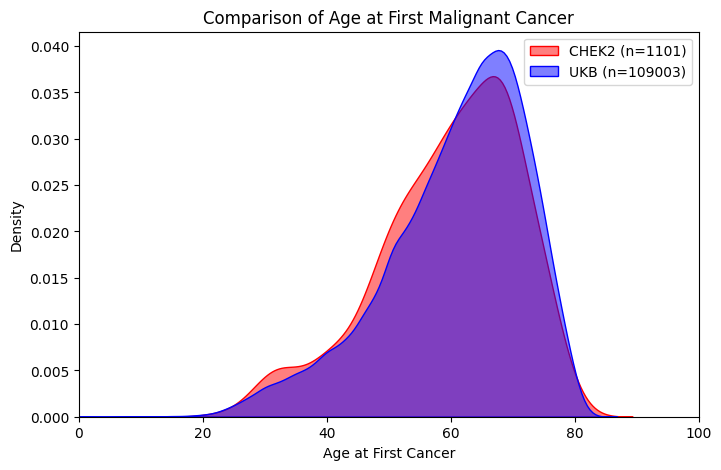

In [11]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Extract data
chek2_ages = pheno_chek2_malignancy['Age_at_First_Cancer'].dropna()
ukb_ages = pheno_ukb_malignancy['Age_at_First_Cancer'].dropna()

# Kolmogorov-Smirnov Test
ks_stat, ks_pval = stats.ks_2samp(chek2_ages, ukb_ages)

# Mann-Whitney U Test
mw_stat, mw_pval = stats.mannwhitneyu(chek2_ages, ukb_ages, alternative='two-sided')

# T-test (if data is normally distributed)
t_stat, t_pval = stats.ttest_ind(chek2_ages, ukb_ages, equal_var=False)

# Print results
print(f"Kolmogorov-Smirnov Test: Stat = {ks_stat:.4f}, p-value = {ks_pval:.4e}")
print(f"Mann-Whitney U Test: Stat = {mw_stat:.4f}, p-value = {mw_pval:.4e}")

# Visualization
plt.figure(figsize=(8, 5))
sns.kdeplot(chek2_ages, label="CHEK2 (n=1101)", color="red", fill=True, alpha=0.5)
sns.kdeplot(ukb_ages, label="UKB (n=109003)", color="blue", fill=True, alpha=0.5)
plt.xlabel("Age at First Cancer")
plt.ylabel("Density")
plt.title("Comparison of Age at First Malignant Cancer")
plt.legend()
plt.xlim(0, 100)
plt.show()


Penetrace Calculations

Threshold: 10
With Cancer: 0
Total Individuals: 3762
Threshold: 20
With Cancer: 0
Total Individuals: 3762
Threshold: 30
With Cancer: 15
Total Individuals: 3762
Threshold: 40
With Cancer: 78
Total Individuals: 3762
Threshold: 50
With Cancer: 213
Total Individuals: 3762
Threshold: 60
With Cancer: 507
Total Individuals: 3762
Threshold: 70
With Cancer: 903
Total Individuals: 3762
Threshold: 80
With Cancer: 1098
Total Individuals: 3762
Threshold: 90
With Cancer: 1101
Total Individuals: 3762


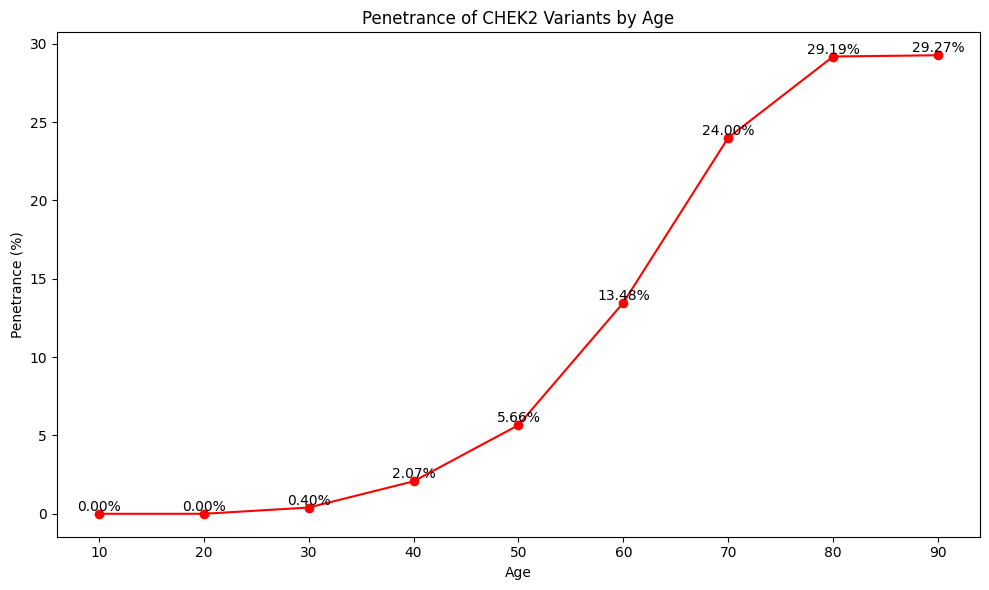

In [12]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

# Define age thresholds
age_thresholds = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# Target values for filtering
target_values = {2.0, 3.0, 6.0, 9.0}

# Initialize a list to store penetrance results
penetrance_results = []

# Loop through each age threshold and calculate penetrance
for threshold in age_thresholds:
    print(f"Threshold: {threshold}")

    # Filter individuals at or below the age threshold
    age_group = phenotype_chek2[phenotype_chek2['Age_at_First_Cancer'] <= threshold].copy()

    # Convert string lists to actual lists if necessary
    age_group['Behavior'] = age_group['Behavior'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # Filter individuals with target values in the Behavior column
    age_filter = age_group[age_group['Behavior'].apply(lambda x: any(val in target_values for val in (x if isinstance(x, list) else [x])))]

    # If the filtered DataFrame is empty, set with_cancer to 0
    with_cancer = age_filter['Behavior'].notna().sum() if not age_filter.empty else 0

    print(f"With Cancer: {with_cancer}")

    # Calculate the total number of individuals (original dataset)
    total_individuals = len(phenotype_chek2)
    print(f"Total Individuals: {total_individuals}")

    # Calculate penetrance percentage
    penetrance = (with_cancer / total_individuals) * 100 if total_individuals > 0 else 0
    penetrance_results.append((threshold, penetrance))

# Convert results into a DataFrame
penetrance_df = pd.DataFrame(penetrance_results, columns=['Age Threshold', 'Penetrance (%)'])



# Plot results
plt.figure(figsize=(10, 6))
plt.plot(penetrance_df['Age Threshold'], penetrance_df['Penetrance (%)'], marker='o', linestyle='-', color='red')

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Penetrance (%)')
plt.title('Penetrance of CHEK2 Variants by Age')

# Add values on top of the plot
for i in range(len(penetrance_df)):
    plt.text(penetrance_df['Age Threshold'][i], penetrance_df['Penetrance (%)'][i], 
             f'{penetrance_df["Penetrance (%)"][i]:.2f}%', ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.show()